In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nltk.download('stopwords')

In [2]:
df = pd.read_csv("data.csv")
df.drop_duplicates(subset="full_text", inplace=True)
df.dropna(subset=["full_text"], inplace=True)


In [3]:
spam_keywords = [
    # Ditemukan dalam data (indikasi transaksi/promosi)
    r"promo", r"diskon", r"murah", r"jual", r"beli", 
    r"gratis", r"hadiah", r"bonus", r"link", r"klik",
    r"cek", r"ready", r"stock", r"hubungi",
    
    # Kata umum spam (antisipasi)
    r"voucher", r"giveaway", r"slot", r"gacor", 
    r"wa", r"whatsapp", r"admin", r"cs", 
    r"08",  # Pola awal nomor HP
    r"bio", r"follback", r"menang"
]

def is_spam(text):
    text_low = text.lower()
    for k in spam_keywords:
        if re.search(k, text_low):
            return True
    return False

df = df[~df["full_text"].apply(is_spam)]

In [4]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stopwords_indo = set(stopwords.words("indonesian"))

extra_stopwords = {
    # 1. Noise & Artefak Twitter/Media Sosial (Sangat direkomendasikan dihapus)
    "https", "co", "t", "amp",  # "amp" sisa dari &amp;
    "rt", "u", "1", "2", "3",    # Angka seringkali tidak bermakna di sini
    
    # 2. Kata Slang & Singkatan Umum (Tidak ada di library standar)
    "yg", "gak", "ga", "aja", "tuh", "sih",
    "kalo", "udah", "dr", "krn", "utk", "jd",
    "karna", "krna", "jg", "juga", "ni", "tu",
    "nak", "sbb", "tak", "je", "kat", # Slang/kata Melayu umum (muncul di data)
    
    # 3. Kata Penghubung/Umum yang Sering Muncul (High Frequency Words)
    "ini", "itu", "dan", "di", "ke", "dari",
    "yang", "ada", "untuk", "dengan", "dalam",
    "pada", "atau", "adalah", "karena", "seperti",
    "bisa", "mau", "buat", "jadi", "kan", "ya",
    "nya", "pun", "kok", "lah", "dong", "deh"
}


stopwords_all = stopwords_indo.union(extra_stopwords)


def clean_text(text):
    text = text.lower()

    text = re.sub(r"http\S+|www\S+|bit\.ly/\S+", "", text)

    text = re.sub(r'(.)\1+', r'\1', text)

    text = re.sub(r"@[A-Za-z0-9_]+", "", text)

    text = re.sub(r"#", "", text)

    text = re.sub(r"\brt\b", "", text)

    text = re.sub(r"[0-9]+", "", text)

    text = re.sub(r"[^\w\s]", " ", text)

    text = text.encode("ascii", "ignore").decode("ascii")

    text = re.sub(r"\s{2,}", " ", text).strip()

    words = text.split()

    words = [w for w in words if w not in stopwords_all and len(w) > 2]

    words = [stemmer.stem(w) for w in words]

    words = [w for w in words if len(w) > 1]

    return " ".join(words)


df["clean"] = df["full_text"].apply(clean_text)
df = df[df["clean"].str.strip() != ""]


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^

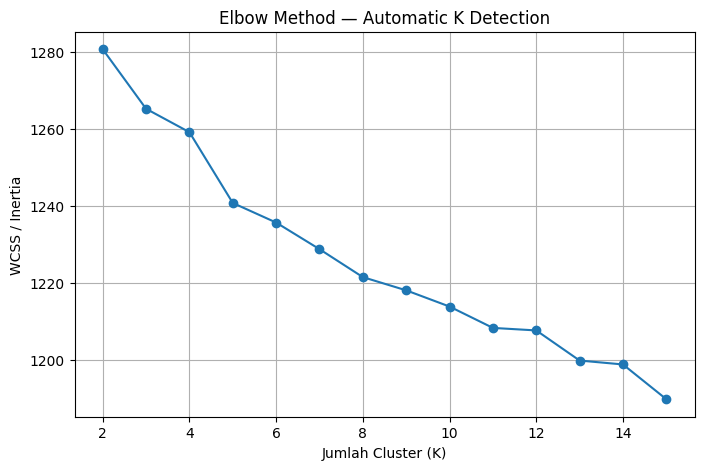

In [5]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["clean"])

def get_best_k_by_elbow(wcss):
    wcss_diff = np.diff(wcss)                 
    wcss_diff2 = np.diff(wcss_diff)           
    best_k_index = np.argmax(wcss_diff2) + 2 
    return best_k_index

wcss = []
K = range(2, 16) 


for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    wcss.append(km.inertia_)


plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.title("Elbow Method — Automatic K Detection")
plt.xlabel("Jumlah Cluster (K)")
plt.ylabel("WCSS / Inertia")
plt.grid(True)
plt.show()

In [11]:
best_k = get_best_k_by_elbow(wcss)
print(f"\n=== Jumlah K terbaik menurut Elbow Method: {best_k} ===")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df["cluster"] = kmeans.fit_predict(X)

terms = tfidf.get_feature_names_out()

print("\n=== TOP WORDS PER CLUSTER ===")

# Membuat DataFrame dari centroid agar mudah diolah
df_centers = pd.DataFrame(kmeans.cluster_centers_, columns=terms)

for idx, row in df_centers.iterrows():
    # Mengambil 15 kata dengan bobot tertinggi secara langsung
    top_words = row.nlargest(15).index.tolist()
    print(f"\nCluster {idx}: {', '.join(top_words)}")


=== Jumlah K terbaik menurut Elbow Method: 4 ===

=== TOP WORDS PER CLUSTER ===

Cluster 0: bikin, kilang, mafia, minyak, impor, bakar, import, pertamina, negara, klo, malas, indonesia, harga, korupsi, oplos

Cluster 1: bakar, dumai, kilang, pertamina, minyak, ledak, purbaya, unit, aman, riau, menkeu, malam, langsung, jadi, madam

Cluster 2: kilang, pertamina, energi, produksi, nasional, minyak, kerja, tahan, kuat, genjot, moga, langkah, operasi, bakar, indonesia

Cluster 3: bangun, kilang, pertamina, impor, purbaya, minyak, malas, menkeu, bahlil, singapura, bakar, kritik, indonesia, janji, kurang


In [12]:
# 1. Mempersiapkan Data untuk Gensim
tokenized_data = [text.split() for text in df["clean"]]
id2word = corpora.Dictionary(tokenized_data)

# 2. Membuat Corpus (Bag of Words)
bow_corpus = [id2word.doc2bow(text) for text in tokenized_data]

# 3. Konfigurasi & Training Model
params = {
    'num_topics': 5,
    'passes': 10,
    'random_state': 42
}

lda_model = models.LdaModel(corpus=bow_corpus, id2word=id2word, **params)

# 4. Menampilkan Hasil
print("\n" + "="*15 + " HASIL TOPIK " + "="*15)
topics = lda_model.show_topics(formatted=False)

for idx, topic_content in topics:
    # Mengambil kata-katanya saja (list comprehension)
    words = [word for word, prob in topic_content]
    print(f"Topik {idx} -> {', '.join(words)}")


=============== HASIL TOPIK ===============
Topik 0 -> kilang, bakar, pertamina, dumai, minyak, bangun, aman, riau, kerja, ledak
Topik 1 -> kilang, bangun, minyak, pertamina, energi, nasional, produksi, kuat, tahan, impor
Topik 2 -> kilang, minyak, pertamina, impor, butuh, indonesia, kerja, harga, negeri, produksi
Topik 3 -> kilang, pertamina, bakar, minyak, purbaya, bangun, bikin, malas, menkeu, impor
Topik 4 -> kilang, pertamina, bakar, dumai, balikpapan, impor, operasi, unit, kerja, proyek


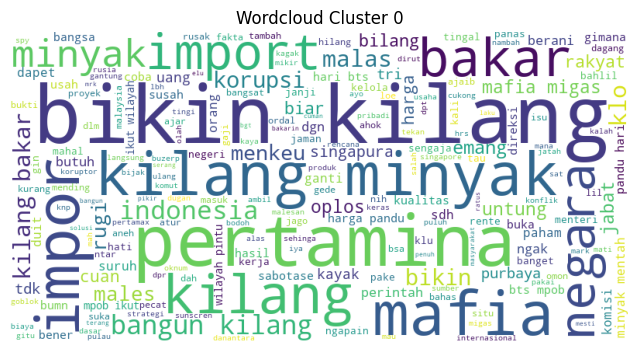

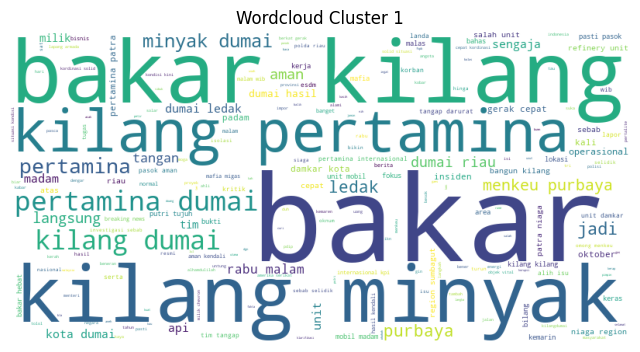

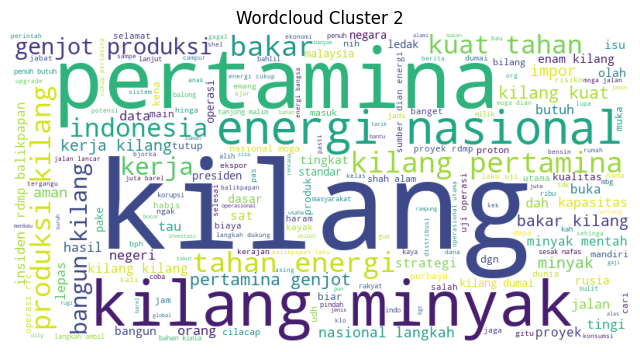

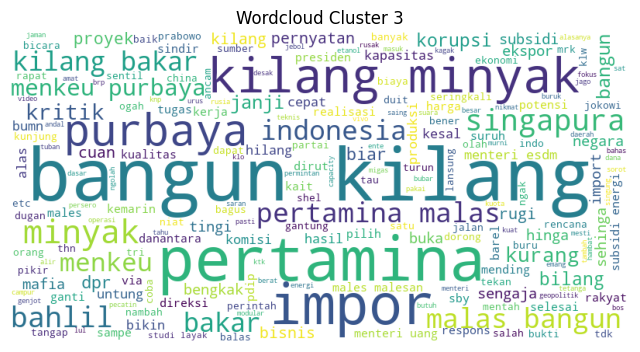

Cluster 4 kosong → dilewati.
Cluster 5 kosong → dilewati.
Cluster 6 kosong → dilewati.
Cluster 7 kosong → dilewati.
Cluster 8 kosong → dilewati.
Cluster 9 kosong → dilewati.
Cluster 10 kosong → dilewati.
Cluster 11 kosong → dilewati.
Cluster 12 kosong → dilewati.
Cluster 13 kosong → dilewati.
Cluster 14 kosong → dilewati.


In [13]:
for i in range(k):
    text = " ".join(df[df["cluster"] == i]["clean"])

    if len(text.strip()) == 0:
        print(f"Cluster {i} kosong → dilewati.")
        continue

    plt.figure(figsize=(8,6))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Wordcloud Cluster {i}")
    plt.show()
